# EDA for digits data

### Determine run parameters

In [1]:
# ----------------- Parameters for interactive development --------------
P = {
    "pipeline.data_lake_root": "/pipeline-outputs/data-lake",
}

In [2]:
# - During automated runs parameters will be injected in the below cell -

In [3]:
# Parameters
P = {
    "pipeline.data_lake_root": "/pipeline-outputs/data-lake",
    "pipeline.run_environment": "ci",
    "pipeline.pipeline_run_id": "6c33327a-27e1-404a-81a7-ffd008d84d60",
    "pipeline.github.repository": "pynb-dag-runner/mnist-digits-demo-pipeline",
    "pipeline.github.workflow": "Run automated tests, pipeline and deploy results to static reporting site",
    "pipeline.github.runner_name": "GitHub Actions 2",
    "pipeline.github.run_id": "2630104459",
    "pipeline.github.actor": "matiasdahl",
    "pipeline.github.job": "run-tests-pipeline-and-persist-pipeline-outputs",
    "pipeline.github.base_ref": "development",
    "pipeline.github.head_ref": "try-C-hyperparameter",
    "pipeline.github.sha": "1c817c9dee14ac98f14dda197d89dc60a81cf438",
    "pipeline.github.ref": "refs/pull/55/merge",
    "pipeline.github.ref_type": "branch",
    "pipeline.github.ref_name": "55/merge",
    "pipeline.github.event_name": "pull_request",
    "task.notebook": "notebooks/eda.py",
    "task.max_nr_retries": "1",
    "run.retry_nr": "0",
    "task.timeout_s": "None",
    "task.num_cpus": 1,
    "_opentelemetry_traceparent": "00-ae4c0ddb7a61dbf5c3ae6948e197b9ab-9761f34600d57e76-01",
}


In [4]:
# -----------------------------------------------------------------------

---

### Notebook code

In [5]:
from typing import Dict, Tuple

#
import collections
import matplotlib.pyplot as plt


#
from pynb_dag_runner.tasks.task_opentelemetry_logging import PydarLogger

#
from common.io import datalake_root, read_numpy

In [6]:
logger = PydarLogger(P)

2022-07-07 14:13:30,765	INFO worker.py:842 -- Connecting to existing Ray cluster at address: 172.17.0.2:6379


In [7]:
X = read_numpy(datalake_root(P) / "raw" / "digits.numpy")
y = read_numpy(datalake_root(P) / "raw" / "labels.numpy")

## Check shapes of digit image and label vectors

In [8]:
X.shape, y.shape

((1797, 64), (1797,))

In [9]:
# labels in y has shape of vector
assert y.shape == (len(y),)

# X and y have compatible shape (ie., both have equal number of rows)
assert X.shape[0] == len(y) == y.shape[0]

# each image is 8x8 pixels
assert X.shape[1] == 8 * 8

In [10]:
logger.log_int("nr_digits", len(y))
logger.log_int("pixels_per_digit", int(X.shape[1]))

 - Logging nr_digits (int) : 1797
 - Logging pixels_per_digit (int) : 64


## Check distribution of labels

In [11]:
def plot_dict_to_barplot(
    values_dict: Dict[int, int],
    title: str,
    x_label: str,
    y_label: str,
    figsize: Tuple[int, int] = (16, 5),
    font_size: int = 18,
    title_font_size: int = 22,
):
    """
    Draw bar plots from count data in a dict
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

    keys, counts = zip(*values_dict.items())  # type: ignore
    ax.bar(keys, counts)
    ax.set_xticks(keys)

    ax.set_title(title + "\n", fontsize=title_font_size)

    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label + "\n", fontsize=font_size)

    ax.tick_params(axis="both", which="major", labelsize=font_size)

    fig.tight_layout()

    return fig

In [12]:
# all labels in y are in set 0, 1, ..., 8, 9 (possible digits)
assert set(y) == set(range(10))

In [13]:
digit_counts: Dict[int, int] = dict(collections.Counter(y))

logger.log_value("counts_per_digit", {str(k): v for k, v in digit_counts.items()})

 - Logging counts_per_digit (json) : {'0': 178, '1': 182, '2': 177, '3': 183, '4': 181, '5': 182, '6': 181, '7': 179, '8': 174, '9': 180}


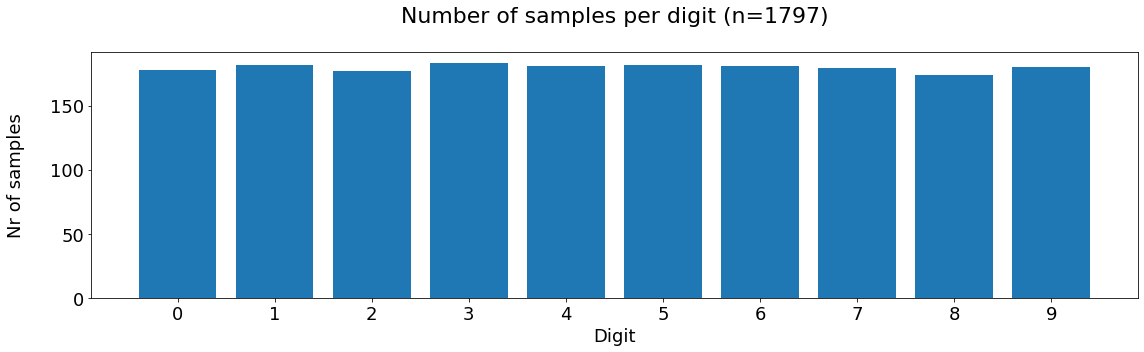

In [14]:
fig = plot_dict_to_barplot(
    digit_counts,
    title=f"Number of samples per digit (n={len(y)})",
    x_label="Digit",
    y_label="Nr of samples",
)

In [15]:
logger.log_figure("logged-images/samples_per_digit.png", fig)

- All digits 0, 1, ..., 8, 9 are (approximatively) equally represented in the data set

## Check distribution of pixel values

In [16]:
assert X.reshape(-1).shape == (X.shape[0] * X.shape[1],)

In [17]:
# all labels in y are in set 0, 1, ..., 8, 9 (possible digits)
assert set(X.reshape(-1)) == set(float(x) for x in range(17))

In [18]:
pixel_value_counts: Dict[int, int] = dict(collections.Counter(X.reshape(-1)))

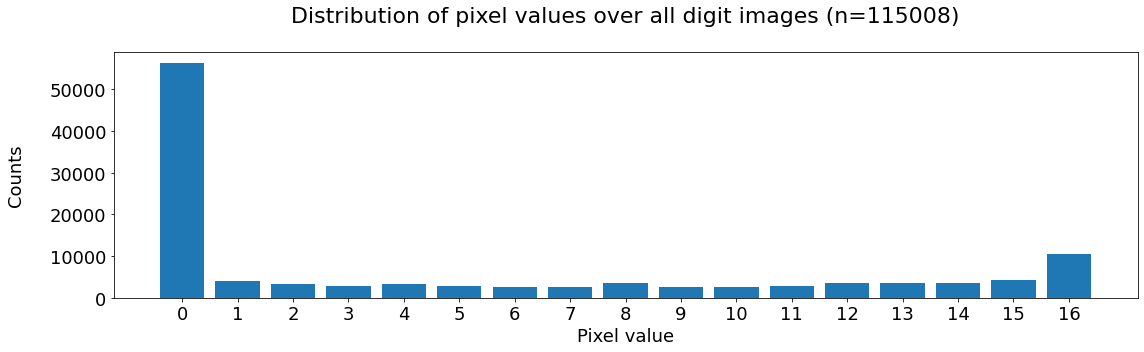

In [19]:
fig = plot_dict_to_barplot(
    pixel_value_counts,
    title=f"Distribution of pixel values over all digit images (n={len(X.reshape(-1))})",
    x_label="Pixel value",
    y_label="Counts",
)

In [20]:
logger.log_figure("logged-images/pixel_value_counts.png", fig)

- The pixel values in the images are encoded with numbers 0, .., 16.
- Pixel value 0 occur most frequently (background color).
- The second most frequent pixel value is 16.0 (digit draw color).

## Plot individual digit images

In [21]:
from common.utils import chunkify, make_panel_image

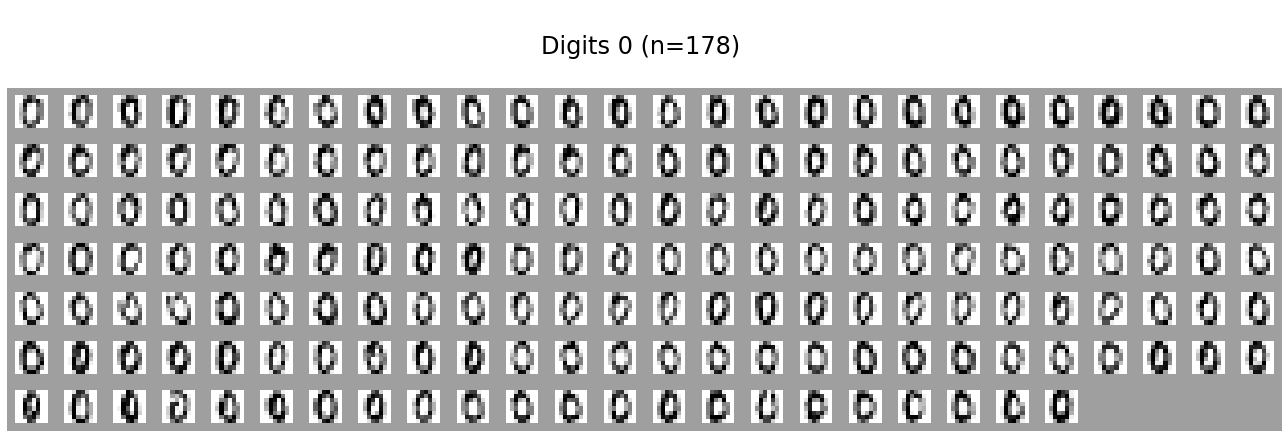

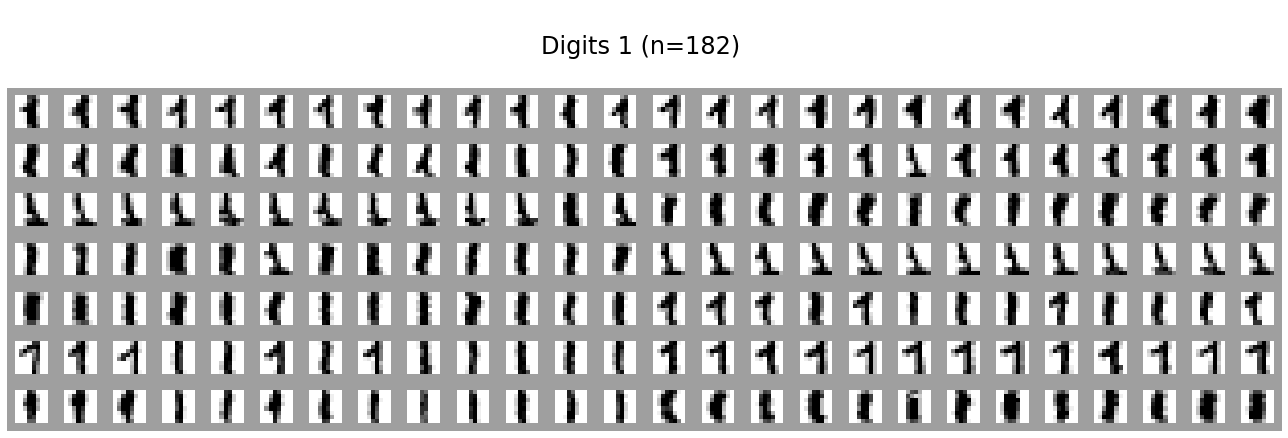

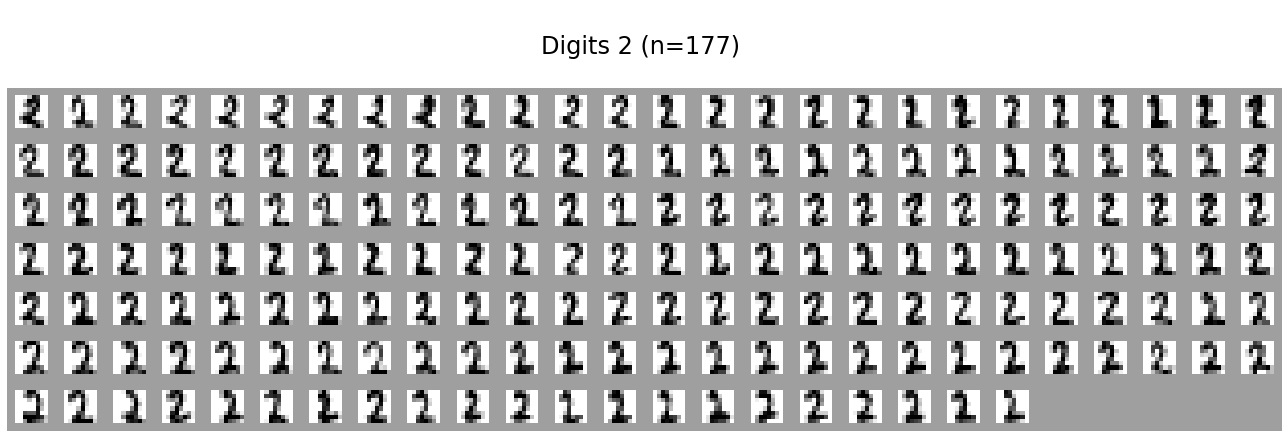

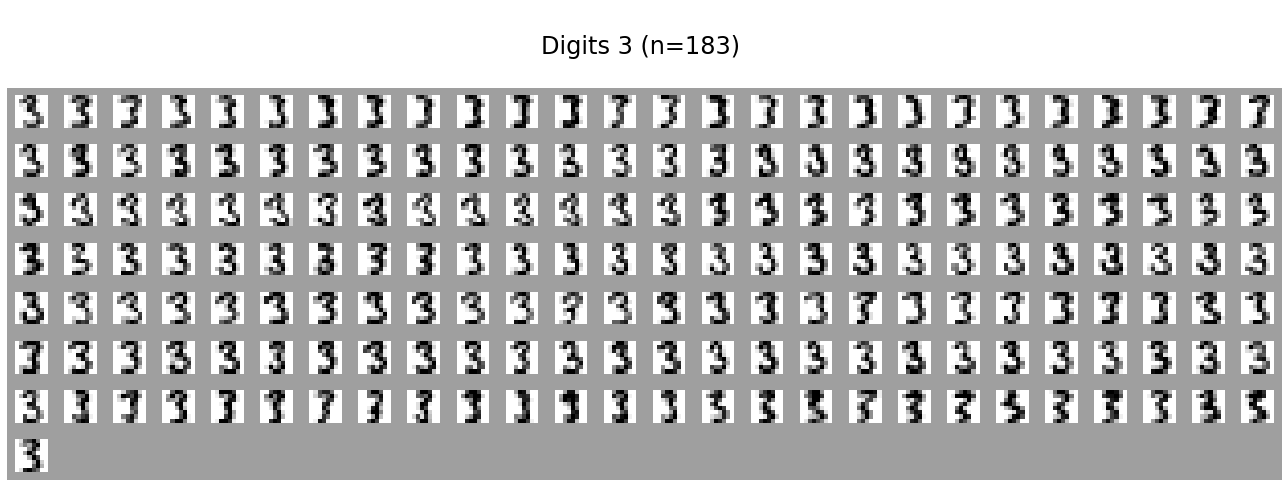

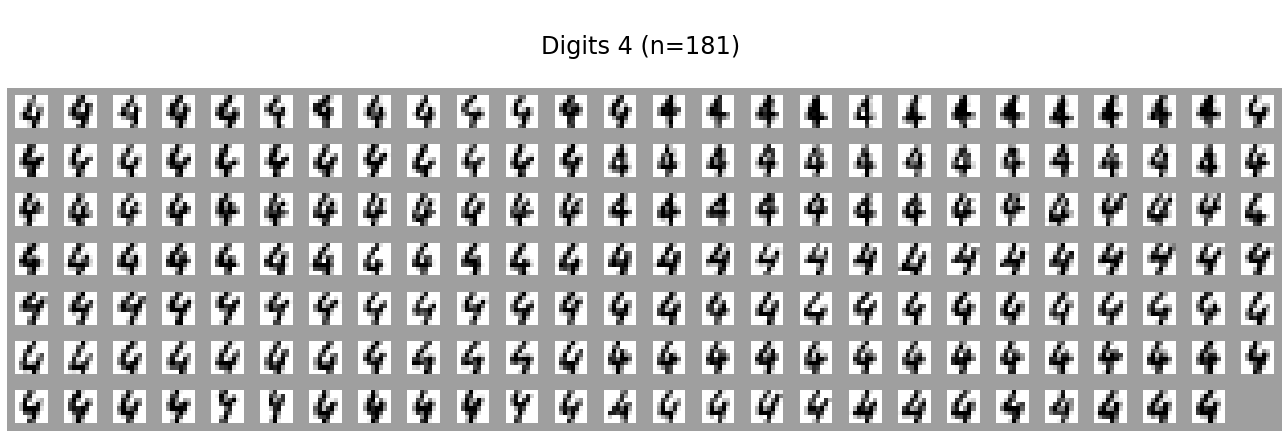

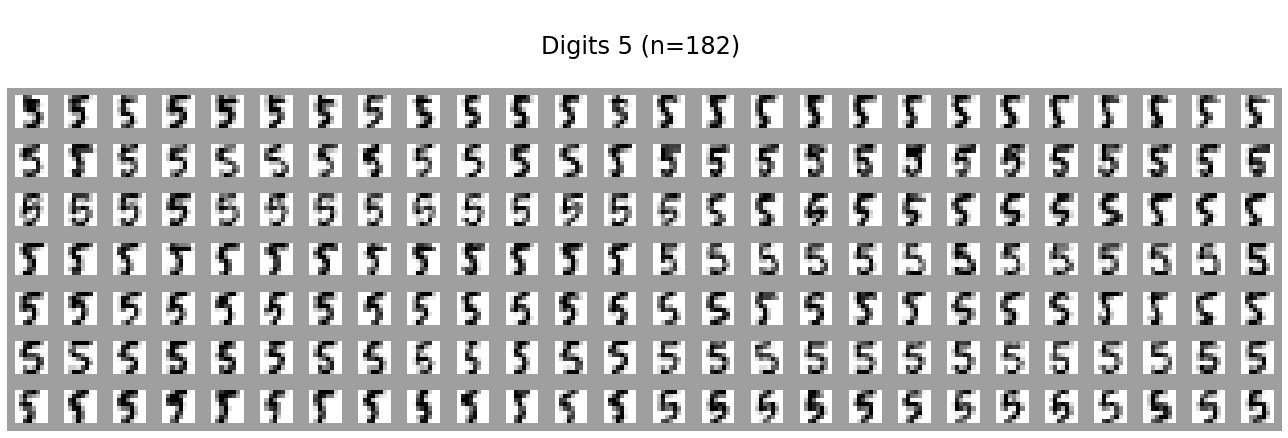

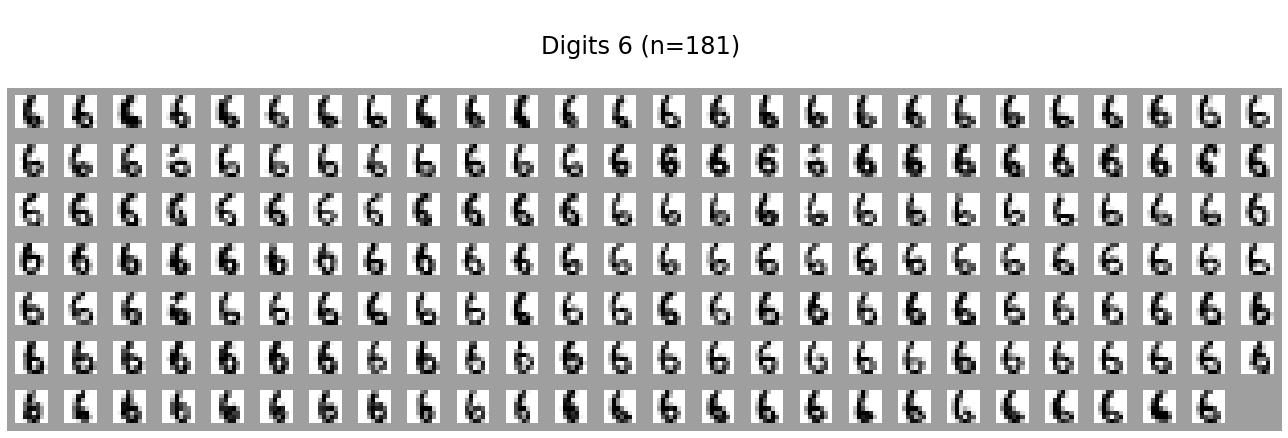

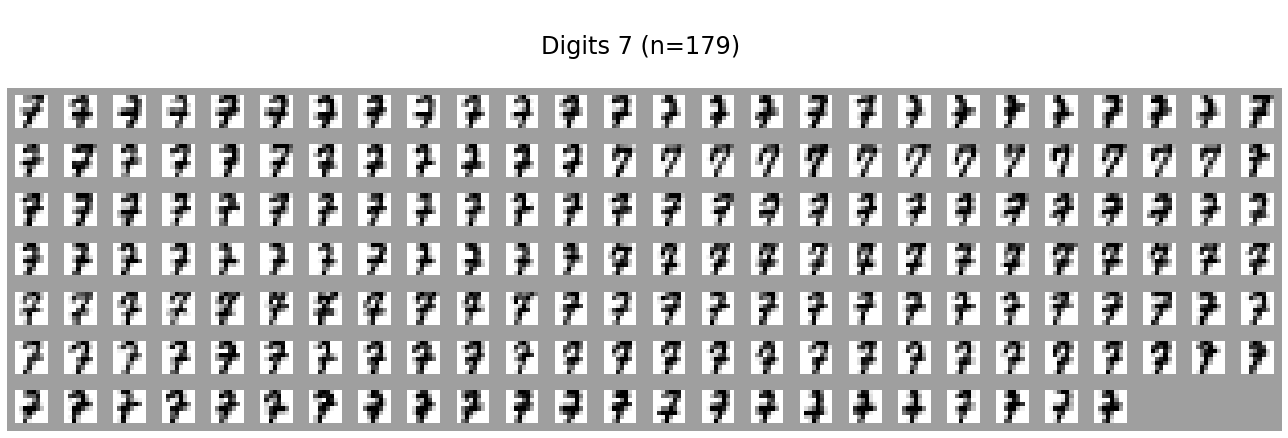

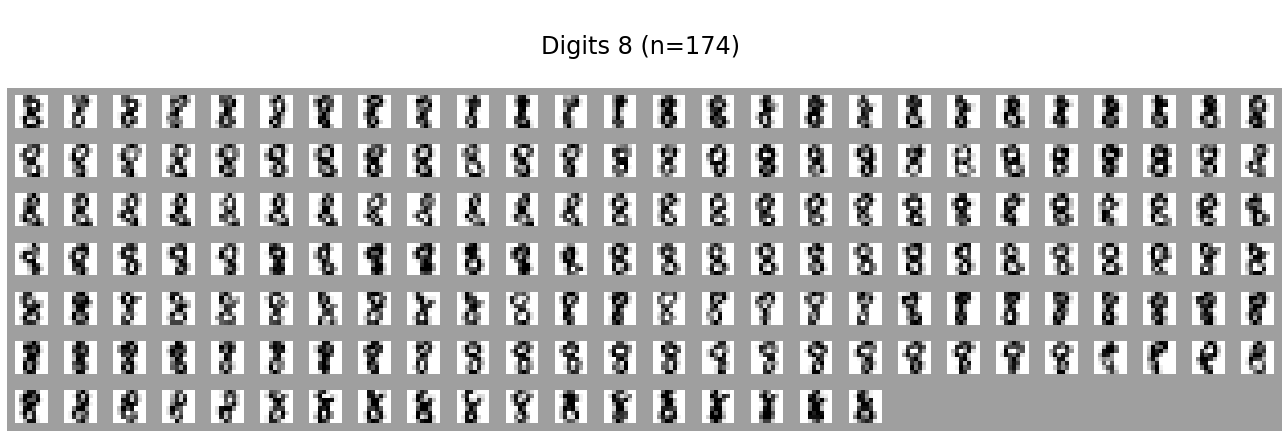

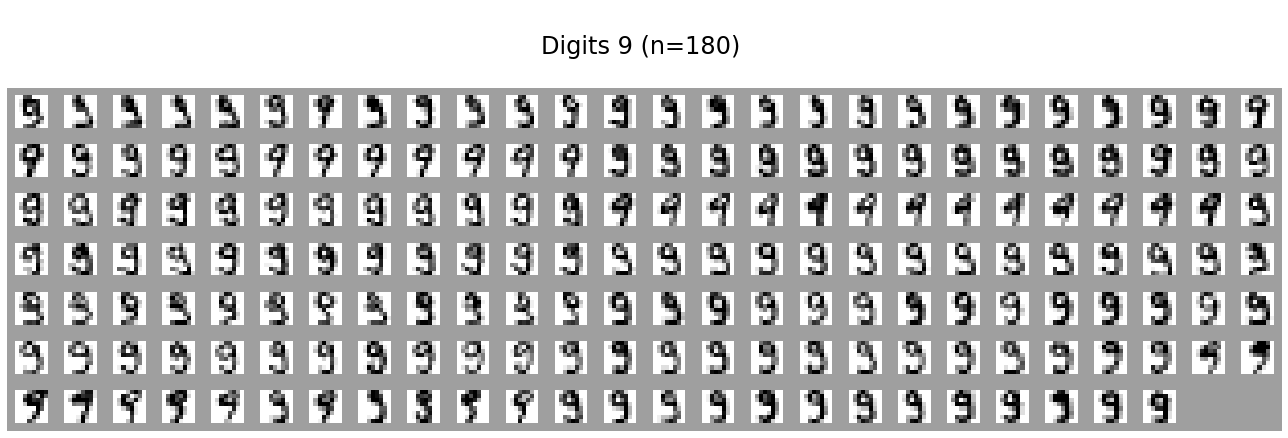

In [22]:
for digit in range(10):
    X_digit = X[y == digit].reshape(-1, 8, 8)

    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(18, 30))

    ax.set_title(f"\nDigits {digit} (n={len(X_digit)}) \n", fontsize=24)
    ax.axis("off")

    ax.imshow(
        make_panel_image(X_digit, pad_width=2, background_fill=6, images_per_row=26),
        cmap=plt.cm.gray_r,
    )

    fig.tight_layout()
    fig.show()

    logger.log_figure(f"logged-images/digits/{digit}-images.png", fig)

In [23]:
###